In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

In [2]:
! pip install bert-score

In [3]:
# Import data
# Load all splits
splits = {'train': 'train.csv', 'validation': 'validation.csv', 'test': 'test.csv'}
dfs = {split: pd.read_csv(f"hf://datasets/knkarthick/samsum/{path}") for split, path in splits.items()}

# Use train split for initial EDA
df = dfs['train']

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
# Basic info
print("Shape of dataset:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())
print("\nSample Rows:\n", df.sample(5))


Shape of dataset: (14732, 3)

Data Types:
 id          object
dialogue    object
summary     object
dtype: object

Missing Values:
 id          0
dialogue    1
summary     0
dtype: int64

Sample Rows:
              id                                           dialogue  \
20     13716048  Ashley: Guys, you have to read this book!  <fi...   
7956   13730928  Mike: hey let me help you with the project\nBl...   
14140  13680374  Wesley: what's 4 dinner?\nSelena: lasagne\nWes...   
942    13730026  Justin: look, why dont you let me take you out...   
371    13728443  Ingrid: Sweet! Thank you!\nHal: I knew you'd l...   

                                                 summary  
20     Erin is convinced by Ashley's book recommendat...  
7956   Mike offers to help Blake with his project. Bl...  
14140    Wesley and Selena will have lasagna for dinner.  
942    Justin will pick Cecilia up at noon today and ...  
371    Ingrid will be waiting for Hal at home at 7 to...  


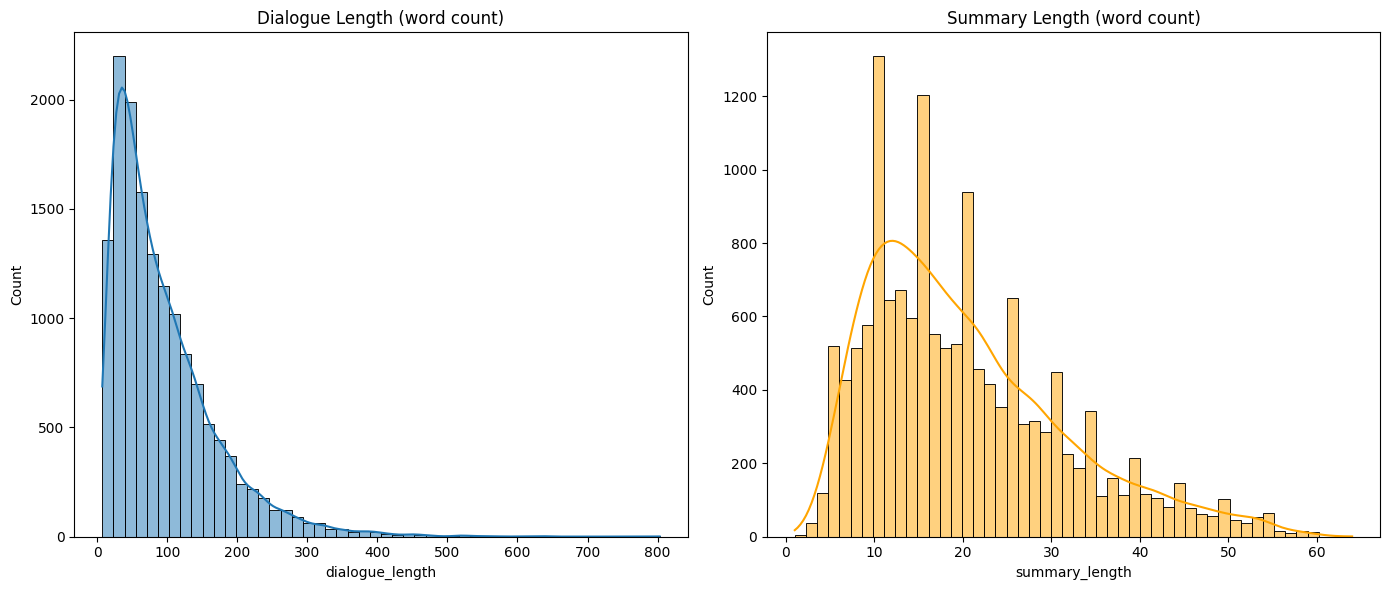

In [5]:
# Text length analysis

# Drop 'dialogue' NAN
df = df.dropna(subset=['dialogue']).copy()

df['dialogue_length'] = df['dialogue'].apply(lambda x: len(x.split()))
df['summary_length'] = df['summary'].apply(lambda x: len(x.split()))

# Plot distributions
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
sns.histplot(df['dialogue_length'], bins=50, kde=True)
plt.title("Dialogue Length (word count)")

plt.subplot(1, 2, 2)
sns.histplot(df['summary_length'], bins=50, kde=True, color='orange')
plt.title("Summary Length (word count)")

plt.tight_layout()
plt.show()


In [6]:
# Unique values analysis
print("Unique summaries:", df['summary'].nunique())
print("Unique dialogues:", df['dialogue'].nunique())

# Look at some long and short examples
print("\nLongest Dialogue:\n", df.loc[df['dialogue_length'].idxmax(), 'dialogue'])
print("\nCorresponding Summary:\n", df.loc[df['dialogue_length'].idxmax(), 'summary'])


Unique summaries: 14729
Unique dialogues: 14255

Longest Dialogue:
 Ash: Thanks so much! I am feeling so much better. I'm gonna work on the next chapter as soon as I can. I'm hoping to actually work on it tonight, but I have to beta another story. Thanks again!!!
Mollie: Please do! I love all your stories but this one cuts the cake. :) I'm glad to hear you're feeling better :D and have fun Beta-ing! :P
Mollie: P.S. Can I ask dor a small-ish favour? Could you make Clara say (in that last chapter): "run you clever boy" or something like that? If not I get it :P
Ash: I'm not sure if I can in the last chapter, BUT I was thinking about it...I might be able to make another itty bitty cameo with he...and I might be able to have her say it... I gotta think about how to incorporate it! 
Mollie: There is an option to edit chapters - it's really weird but manageable. Wither way, having Clara back would be exciting :D
Ash: Yeah... I know how to do that. I just wasn't sure if it made sense for her 

In [7]:
# Check for duplicated rows or summaries
print("Duplicated dialogues:", df.duplicated('dialogue').sum())
print("Duplicated summaries:", df.duplicated('summary').sum())


Duplicated dialogues: 476
Duplicated summaries: 2


In [8]:
df[df.duplicated('summary', keep=False)].sort_values('summary').head(10)


,id,dialogue,summary,dialogue_length,summary_length
8742,13862978,Frank: you look amazin' today <3\nMacy: <3\nMa...,Frank likes Macy's red outfit.,21,5
9225,13828470,Frank: you look amazin' today <3\nMacy: <3\nMa...,Frank likes Macy's red outfit.,21,5
12367,13731178,Tim: How's oreo?\nSeth: worse :/\nTim: shiiit\...,Seth's pet Oreo that he got when he was 10 is ...,114,34
13377,13809905,Tim: How's oreo?\nSeth: worse :/\nTim: shiiit\...,Seth's pet Oreo that he got when he was 10 is ...,114,34


In [9]:
# Drop duplicate summaries
df = df.drop_duplicates(subset=['summary']).copy()

In [10]:
# Duplicate dialogue inspection
df[df.duplicated('dialogue', keep=False)].sort_values('dialogue').head(10)


,id,dialogue,summary,dialogue_length,summary_length
7009,13716423,"Abby: Boys, does anyone know how to fix a tap?...",Lucas will take care of Abby's dripping tap. S...,48,15
11153,13818866,"Abby: Boys, does anyone know how to fix a tap?...",Lucas will fix a dripping tap for Abby.,48,8
12211,13730605,Abigail: Have you thought about what you might...,Abigail and Brittany will go to the beach this...,112,34
9221,13612252,Abigail: Have you thought about what you might...,Abigail and Brittany agreed on going to a musi...,112,15
12233,13810138,Adam: Hey Nina how are you? whats up?\nNina: i...,"Adam, Nina's brother, invites Nina for a get-t...",118,19
8813,13729382,Adam: Hey Nina how are you? whats up?\nNina: i...,Nina is taking care of Peter. Nina will join A...,118,16
1339,13810002,Adam: If you ever think about buying new lapto...,Adam is displeased with his HP laptop which br...,57,20
6222,13729711,Adam: If you ever think about buying new lapto...,Adam's HP laptop broke 3 times last year so he...,57,17
12890,13730739,Adam: hey! can you send me assignment Mr. Pete...,Adam missed school and needs Hannah to send hi...,66,14
5806,13810136,Adam: hey! can you send me assignment Mr. Pete...,Adam didn't come as he wasn't feeling well. Ha...,66,20


In [11]:
# Strip formatting
df['dialogue_clean'] = df['dialogue'].str.strip().str.lower().str.replace(r'\s+', ' ', regex=True)
dupes = df[df.duplicated('dialogue_clean', keep=False)]

# Compare summaries
dupe_groups = dupes.groupby('dialogue_clean')['summary'].nunique()
multiple_summaries = dupe_groups[dupe_groups > 1]

print(multiple_summaries)

dialogue_clean
abby: boys, does anyone know how to fix a tap? sid: what's wrong with it? abby: it's dripping ;( sid: i can fix it, but i'm in manchester at the moment so you'll have to wait three days. lucas: i can take care of it. abby: thank you!                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   2
abigail: have you thought about what you might like to do this weekend? brittany: i have no idea, you? abigail: if the weather stays nice, i'd like to go to the beach. brittany: that woul

Data Preprocessing & Preparation

In [12]:
# Segment 'hi-info' dialogues

def is_high_information(text):
    decision_keywords = r"\b(decided|agreed|confirmed|scheduled|cancelled|rescheduled)\b"
    question_keywords = r"\?"
    response_keywords = r"\b(yes|no|okay|sure|let me|i will|sounds good|thanks)\b"

    return (
        re.search(decision_keywords, text, re.IGNORECASE) or
        re.search(question_keywords, text) or
        re.search(response_keywords, text, re.IGNORECASE)
    )

df['high_info'] = df['dialogue'].apply(lambda x: any(is_high_information(line) for line in x.split('\n')))
df_high_info = df[df['high_info']]

print(df_high_info)


             id                                           dialogue  \
0      13818513  Amanda: I baked  cookies. Do you want some?\nJ...   
1      13728867  Olivia: Who are you voting for in this electio...   
2      13681000  Tim: Hi, what's up?\nKim: Bad mood tbh, I was ...   
3      13730747  Edward: Rachel, I think I'm in ove with Bella....   
4      13728094  Sam: hey  overheard rick say something\nSam: i...   
...         ...                                                ...   
14727  13863028  Romeo: You are on my ‘People you may know’ lis...   
14728  13828570  Theresa: <file_photo>\nTheresa: <file_photo>\n...   
14729  13819050  John: Every day some bad news. Japan will hunt...   
14730  13828395  Jennifer: Dear Celia! How are you doing?\nJenn...   
14731  13729017  Georgia: are you ready for hotel hunting? We n...   

                                                 summary  dialogue_length  \
0      Amanda baked cookies and will bring Jerry some...               16   
1    

In [13]:
# Training pairs
# Select only the needed columns
train_pairs = df_high_info[['dialogue', 'summary']].rename(columns={'dialogue': 'input_text', 'summary': 'target_text'})

# Preview a few examples
print(train_pairs.sample(3))

                                              input_text  \
1892   Vic: Hiii!\nCharles: Hioow!\nVic: Have you see...   
12658  Sylvia: what will you sing today?\nCecilia: i ...   
14617  Gage: did you have good time with my friend? <...   

                                             target_text  
1892   Vic has uploaded a new Foo Fighters cover to h...  
12658  Cecilia is in a bad mood but she will join Syl...  
14617  Gage set the date up for Amber and his friend,...  


In [14]:
# Convert present to future in common patterns
def normalize_tense(summary):
    summary = re.sub(r"\b(is|are|will be)\b", "will be", summary)
    summary = re.sub(r"\b(goes|go|going)\b", "will go", summary)
    summary = re.sub(r"\b(has|have)\b", "will have", summary)
    summary = re.sub(r"\b(meets|meet|meeting)\b", "will meet", summary)
    return summary

In [15]:
# Tokenize using WordPiece
from transformers import BertTokenizer

# Load a BERT-compatible WordPiece tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize input-output pairs
train_pairs['input_tokens'] = train_pairs['input_text'].apply(lambda x: tokenizer(x, truncation=True, padding='max_length', max_length=512))
train_pairs['target_tokens'] = train_pairs['target_text'].apply(lambda x: tokenizer(x, truncation=True, padding='max_length', max_length=128))


Model Architecture Selection & Implementation

In [16]:
from transformers import (
    BartForConditionalGeneration, BartTokenizer,
    PegasusForConditionalGeneration, PegasusTokenizer,
    Trainer, TrainingArguments, DataCollatorForSeq2Seq
)
from datasets import Dataset
import torch

# BART model
model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

# # Fix summary tenses
# df["summary"] = df["summary"].apply(normalize_tense)

# Prepare Dataset
dataset = Dataset.from_dict(df)

# Shuffle and select a smaller subset for debugging
dataset = dataset.shuffle(seed=42).select(range(600))

def preprocess_function(examples):
    model_inputs = tokenizer(examples["dialogue"], max_length=400, truncation=True, padding="max_length")
    labels = tokenizer(text_target=examples["summary"], max_length=50, truncation=True, padding="max_length")
    labels["input_ids"] = [
        [(tid if tid != tokenizer.pad_token_id else -100) for tid in label]
        for label in labels["input_ids"]
    ]
    model_inputs["labels"] = labels["input_ids"]

    return model_inputs

training_tokenized_dataset = dataset.map(preprocess_function, batched=True)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    logging_dir="./logs",
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=training_tokenized_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

# Fine-tune model
trainer.train()


Map:   0%|          | 0/600 [00:00<?, ? examples/s]

/tmp/ipython-input-16-2923338989.py:47: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: austinmohn1 (austinmohn1-flatiron-school) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3465: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=225, training_loss=1.0641729058159721, metrics={'train_runtime': 349.3584, 'train_samples_per_second': 5.152, 'train_steps_per_second': 0.644, 'total_flos': 1523745423360000.0, 'train_loss': 1.0641729058159721, 'epoch': 3.0})

In [17]:
# Run inference to check output quality

sample_input = dataset[0]['dialogue']
inputs = tokenizer(
    sample_input,
    return_tensors="pt",
    truncation=True,
    max_length=256,
    padding=True
)


# Move input tensors to the model’s device
inputs = {k: v.to(model.device) for k, v in inputs.items()}

# Generate summary
summary_ids = model.generate(
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    max_length=64,
    num_beams=4,
    early_stopping=True
)

summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print("Input:\n", sample_input)
print("\nGenerated Summary:\n", summary)


Input:
 Adam: <file_video>
Adam: what do you think
Hector: give me a sec
Hector: ok watching
Adam: let me know
Hector: can't really hear a lot there ;/
Adam: yeah ;/
Adam: i think i need to record it somehow else
Adam: maybe through the interface and software
Hector: that definitely is a great idea!
Hector: i guess that's why i gave you the interface and installed it :D
Adam: yeah xd
Adam: ok i'll try to figure it out later
Hector: ok
Hector: i'll be waiting :P

Generated Summary:
 Adam wants to record it somewhere else. He will try to figure it out later. Hector gave Adam the interface and he installed it. Hector will watch the video and wait for Adam's response.    i guess that's why Hector gave the interface to Adam and installed


In [18]:
print("Tokens:", tokenizer.tokenize(sample_input))
print("Input IDs:", inputs["input_ids"])


Tokens: ['Adam', ':', 'Ġ<', 'file', '_', 'video', '>', 'Ċ', 'Adam', ':', 'Ġwhat', 'Ġdo', 'Ġyou', 'Ġthink', 'Ċ', 'H', 'ector', ':', 'Ġgive', 'Ġme', 'Ġa', 'Ġsec', 'Ċ', 'H', 'ector', ':', 'Ġok', 'Ġwatching', 'Ċ', 'Adam', ':', 'Ġlet', 'Ġme', 'Ġknow', 'Ċ', 'H', 'ector', ':', 'Ġcan', "'t", 'Ġreally', 'Ġhear', 'Ġa', 'Ġlot', 'Ġthere', 'Ġ;', '/', 'Ċ', 'Adam', ':', 'Ġyeah', 'Ġ;', '/', 'Ċ', 'Adam', ':', 'Ġi', 'Ġthink', 'Ġi', 'Ġneed', 'Ġto', 'Ġrecord', 'Ġit', 'Ġsomehow', 'Ġelse', 'Ċ', 'Adam', ':', 'Ġmaybe', 'Ġthrough', 'Ġthe', 'Ġinterface', 'Ġand', 'Ġsoftware', 'Ċ', 'H', 'ector', ':', 'Ġthat', 'Ġdefinitely', 'Ġis', 'Ġa', 'Ġgreat', 'Ġidea', '!', 'Ċ', 'H', 'ector', ':', 'Ġi', 'Ġguess', 'Ġthat', "'s", 'Ġwhy', 'Ġi', 'Ġgave', 'Ġyou', 'Ġthe', 'Ġinterface', 'Ġand', 'Ġinstalled', 'Ġit', 'Ġ:', 'D', 'Ċ', 'Adam', ':', 'Ġyeah', 'Ġx', 'd', 'Ċ', 'Adam', ':', 'Ġok', 'Ġi', "'ll", 'Ġtry', 'Ġto', 'Ġfigure', 'Ġit', 'Ġout', 'Ġlater', 'Ċ', 'H', 'ector', ':', 'Ġok', 'Ċ', 'H', 'ector', ':', 'Ġi', "'ll", 'Ġbe', 'Ġwaiting

Fine-Tuning & Optimization

In [19]:
! pip install evaluate
! pip install rouge_score

In [20]:
# Fine tune trainings_args
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    num_train_epochs=10,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    warmup_steps=200,
    gradient_accumulation_steps=2,
    gradient_checkpointing=True,
    max_grad_norm=1.0,
    label_smoothing_factor=0.1
)

# Definte compute metrics
from evaluate import load

rouge = load("rouge")

import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # Convert to numpy if not already
    if isinstance(logits, tuple):
        logits = logits[0]
    pred_ids = np.argmax(logits, axis=-1)

    # Convert tensors to lists
    if isinstance(pred_ids, torch.Tensor):
        pred_ids = pred_ids.tolist()
    if isinstance(labels, torch.Tensor):
        labels = labels.tolist()

    labels = [
        [token if token != -100 else tokenizer.pad_token_id for token in label]
        for label in labels
    ]

    decoded_preds = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return {
        "rouge1": result["rouge1"],
        "rouge2": result["rouge2"],
        "rougeL": result["rougeL"]
    }


# Split raw dataset first
split_dataset = dataset.train_test_split(test_size=0.2, seed=42) #increasing to .2

# Then tokenize each split
training_tokenized_dataset = split_dataset.map(preprocess_function, batched=True)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=training_tokenized_dataset["train"],
    eval_dataset=training_tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


Map:   0%|          | 0/480 [00:00<?, ? examples/s]

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

/tmp/ipython-input-20-578422388.py:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training Evaluation & Testing

In [21]:
eval_results = trainer.evaluate()
print("Evaluation Results:")
print(eval_results)


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.58.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Evaluation Results:
{'eval_loss': 2.5489654541015625, 'eval_model_preparation_time': 0.0096, 'eval_rouge1': 0.8513253099113475, 'eval_rouge2': 0.7715716960486976, 'eval_rougeL': 0.8482827864997441, 'eval_runtime': 9.4565, 'eval_samples_per_second': 12.69, 'eval_steps_per_second': 1.586}


In [22]:
! pip install spacy
! python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 11.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [23]:
# Inference test
import spacy
nlp = spacy.load("en_core_web_md")

# Create hallucination log library
hallucination_log = []

# Check for hallucinated tokens
def check_named_entity_consistency(input_text, prediction):
    input_ents = {
            ent.text.lower().strip()
            for ent in nlp(input_text).ents
            if ent.label_ in {"PERSON", "GPE", "ORG", "DATE"}
        }
    pred_ents = {
        ent.text.lower().strip()
        for ent in nlp(prediction).ents
        if ent.label_ in {"PERSON", "GPE", "ORG", "DATE"}
    }

    hallucinated = pred_ents - input_ents
    return hallucinated

for i in range(5):
    input_text = training_tokenized_dataset["test"][i]["dialogue"]
    label = training_tokenized_dataset["test"][i]["summary"]

    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True).to(model.device)
    summary_ids = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=100,
        min_length=15,
        do_sample=True,
        top_p=0.9,
        top_k=50,
        no_repeat_ngram_size=3,
        length_penalty=2.0
    )
    pred = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    # Check for hallucinations
    hallucinated_ents = check_named_entity_consistency(input_text, pred)
    if hallucinated_ents:
        print(f"\nHallucinated Entities {i+1}:", hallucinated_ents)

    # Add hallucinations to library
    hallucination_log.append({
        "input": input_text,
        "prediction": pred,
        "hallucinated_entities": list(hallucinated_ents)
    })

    print(f"\nEXAMPLE {i+1}")
    print("Input:", input_text)
    print("Reference:", label)
    print("Prediction:", pred)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Hallucinated Entities 1: {'sara, ken'}

EXAMPLE 1
Input: Sara: Thanks to the collaborative efforts of the whole tribe, Thanksgiving was an absolute success!!! I’m so thankful to have gotten to celebrate with such an amazing group of people. Thank you all!!!!
Ken: Thank you all for this beautiful collaborative barbaric coma inducing experience. You popped my ;) - now that the feasting is over who is in for some intermittent fasting?
Alex: I’m thankful for being part of such an amazing tribe :)
Anna: you guys are all beautiful humans, thanks for the meal tonight! felt so at home <3 In case anyone feels like cooking some more, here are some thanksgiving leftover recipes I’ve rounded up I thought I’d drop in here! <file_link>
Ken: If anyone is missing dishes or has some from the other houses please put them aside and bring back/ take back when possible. The camp is a little easier but especially for cornerhouse and hotel house please make sure you have everything back.
Kieran: Lets have a

In [24]:
# Export hallucinations
pd.DataFrame(hallucination_log).to_csv("hallucinations.csv", index=False)

In [25]:
# Save model and tokenizer
trainer.save_model("./saved_model")
tokenizer.save_pretrained("./saved_model")


('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.json',
 './saved_model/merges.txt',
 './saved_model/added_tokens.json')

Apply to Full Dataset

In [26]:
from torch.utils.data import Dataset as TorchDataset

class SamsumDataset(TorchDataset):
    def __init__(self, dataframe, tokenizer, max_length_input=400):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length_input = max_length_input

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        dialogue = str(self.dataframe.iloc[idx]['dialogue'])

        encoding = self.tokenizer(
            dialogue,
            truncation=True,
            padding='max_length',
            max_length=self.max_length_input,
            return_tensors='pt'
        )

        # Squeeze to remove batch dimension added by return_tensors='pt'
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze()
        }

In [27]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Optional: Load spaCy for hallucination checking
import spacy
nlp = spacy.load("en_core_web_md")

def check_named_entity_consistency(input_text, prediction):
    input_ents = {ent.text for ent in nlp(input_text).ents if ent.label_ in {"PERSON", "GPE", "ORG", "DATE"}}
    pred_ents = {ent.text for ent in nlp(prediction).ents if ent.label_ in {"PERSON", "GPE", "ORG", "DATE"}}
    hallucinated = pred_ents - input_ents
    return hallucinated

# Prepare dataset using the custom PyTorch Dataset
dataset = SamsumDataset(df, tokenizer)

# Create DataLoader
loader = DataLoader(dataset, batch_size=16)

# Inference loop
all_preds = []
all_hallucinations = []

for i, batch in enumerate(tqdm(loader, desc="Generating summaries")):
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            num_beams=4,
            early_stopping=True,
            min_length=15,
            max_length=100,
            repetition_penalty=1.2,
            no_repeat_ngram_size=3,
            length_penalty=1.2
        )


    decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    # Access original inputs from the 'df' DataFrame using index 'i' and batch size
    original_inputs = df['dialogue'].iloc[i * loader.batch_size : (i + 1) * loader.batch_size].tolist()

    for inp, pred in zip(original_inputs, decoded_preds):
        hallucinated = check_named_entity_consistency(inp, pred)
        all_preds.append(pred)
        all_hallucinations.append(", ".join(hallucinated) if hallucinated else "")

# Save to DataFrame
# Access original dialogue and summary from the 'df' DataFrame
df_export = pd.DataFrame({
    "dialogue": df['dialogue'].tolist(),
    "reference_summary": df['summary'].tolist(),
    "generated_summary": all_preds,
    "hallucinated_entities": all_hallucinations
})

Generating summaries: 100%|██████████| 921/921 [1:49:56<00:00,  7.16s/it]


In [28]:
# Export results dataframe to csv
df_export.to_csv("generated_summaries.csv", index=False)
print("Inference complete. Results saved to 'generated_summaries.csv'")

Inference complete. Results saved to 'generated_summaries.csv'


In [29]:
len(all_preds), len(all_hallucinations)


(14729, 14729)

Evaluation Pt 2

In [30]:
import torch
from evaluate import load
import pandas as pd
import spacy
from tqdm import tqdm
import numpy as np
from transformers import BartTokenizer, BartForConditionalGeneration

# Load model and tokenizer
model_path = "./saved_model"
tokenizer = BartTokenizer.from_pretrained(model_path, local_files_only=True)
model = BartForConditionalGeneration.from_pretrained(model_path, local_files_only=True)

# Load spaCy model for hallucination detection
import spacy
nlp = spacy.load("en_core_web_md")

# Load full dataset from generated responses
full_data = pd.read_csv("generated_summaries.csv")
inputs = full_data["dialogue"].tolist()
references = full_data["reference_summary"].tolist()

# Generate predictions in batches
predictions = full_data["generated_summary"].tolist()

# Filter out examples with missing references or predictions
clean_data = [(inp, ref, pred) for inp, ref, pred in zip(inputs, references, predictions)
              if isinstance(ref, str) and ref.strip() and isinstance(pred, str) and pred.strip()]

inputs, references, predictions = zip(*clean_data)

# Compute ROUGE
rouge = load("rouge")
rouge_result = rouge.compute(predictions=predictions, references=references, use_stemmer=True)

# Check for hallucinated named entities
def get_entities(text):
    return {ent.text.strip() for ent in nlp(text).ents if ent.label_ in {"PERSON", "GPE", "ORG", "DATE"}}

hallucinations = []
for inp, pred in zip(inputs, predictions):
    input_ents = get_entities(inp)
    pred_ents = get_entities(pred)
    hallucinated = pred_ents - input_ents
    hallucinations.append(", ".join(hallucinated) if hallucinated else "")

# Create and export result dataframe
results_df = pd.DataFrame({
    "Input": inputs,
    "Reference": references,
    "Prediction": predictions,
    "Hallucinated_Entities": hallucinations
})

#results_df.to_csv("evaluation_output.csv", index=False)

# Print summary
print("ROUGE scores:")
for k, v in rouge_result.items():
    print(f"{k}: {v:.4f}")

print("\nHallucination Summary:")
num_hallucinated = sum(1 for h in hallucinations if h)
print(f"{num_hallucinated}/{len(hallucinations)} examples with hallucinated entities ({100*num_hallucinated/len(hallucinations):.1f}%)")


/usr/local/lib/python3.11/dist-packages/transformers/models/bart/configuration_bart.py:176: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(


ROUGE scores:
rouge1: 0.5106
rouge2: 0.2577
rougeL: 0.4130
rougeLsum: 0.4129

Hallucination Summary:
5401/14729 examples with hallucinated entities (36.7%)


In [31]:
import random
from IPython.display import display, Markdown

# Number of examples to show
num_examples = 5

# Pick 5 random indices
sample_indices = random.sample(range(len(df_export)), num_examples)

for i in sample_indices:
    dialogue = df_export.loc[i, "dialogue"]
    reference = df_export.loc[i, "reference_summary"]
    generated = df_export.loc[i, "generated_summary"]
    hallucinations = df_export.loc[i, "hallucinated_entities"]

    display(Markdown(f"""
---
###**Dialogue Snippet**
`{dialogue[:500]}...`

###**Reference Summary**
{reference}

###**Generated Summary**
{generated}

###**Hallucinated Entities**
{hallucinations if hallucinations else "None detected"}
"""))



---
###**Dialogue Snippet**
`Niles: How about we have a pizza today instead of cooking?
Rosa: We haven't had one in a long time! Home delivery or dining out?
Niles: Which would you prefer?
Rosa: Well, since our favourite restaurant doesn't do deliveries, I think I'd prefer to eat out
Niles: I'm fine with that. Let's meet up at the station and walk from there....`

###**Reference Summary**
Niles and Rosa will eat pizza today in their favourite pizza place. They will meet at the station.

###**Generated Summary**
Rosa and Niles are going to have pizza. They will meet up at the station and walk from there.

###**Hallucinated Entities**
Rosa



---
###**Dialogue Snippet**
`Filly: wanna go to a concert?
Bonnie: whose?
Filly: Mumford and Sons
Bonnie: who r they?
Filly: u don't know them?
Filly: they r great!
Filly: listen
Filly: <file_video>
Bonnie: ok, they r good
Filly: so will u come?
Bonnie: when?
Filly: next sat
Bonnie: ok :)
Filly: great :D...`

###**Reference Summary**
Bonnie will go to the Mumford and Sons concert with Filly next Saturday.

###**Generated Summary**
Filly and Bonnie are going to see Mumford and Sons concert next week.

###**Hallucinated Entities**
next week, Mumford



---
###**Dialogue Snippet**
`Wayne: Man, have you seen the reviews?
Joe: Yeah, looks like the movie sucks
Wayne: Yeah... dammit :(...`

###**Reference Summary**
According to the reviews, the movie is not that good.

###**Generated Summary**
Wayne and Joe have seen the reviews of "The Crow". They think the movie sucks.

###**Hallucinated Entities**
None detected



---
###**Dialogue Snippet**
`Maxi: Good evening, dear Thekla! Sorry to bother you but
Maxi: got stuck in a traffic jam on Washington Ave.
Thekla: Hello Maxi, oh dear! Is it very bad?
Maxi: By the looks of it yes. A major car accident.
Thekla: We might wait for you.
Maxi: Oh no! Please don't go into any trouble on my account.
Maxi: Just start the evening as planned.
Maxi: If I manage to get to Bolton's before 10, I'll just sneak in and take a seat in the back.
Thekla: How about texting me short when the traffic starts moving...`

###**Reference Summary**
Maxi got stuck in a traffic jam on Washington Ave because of a car accident. He'll be late for the evening at Bolton's. He'll give Thomas a lift. 

###**Generated Summary**
Maxi got stuck in a traffic jam on Washington Ave. Thekla will wait for him. Maxi will try to get to Bolton's before 10 o'clock and take a seat in the back. Thomas was expected to give him a lift.

###**Hallucinated Entities**
None detected



---
###**Dialogue Snippet**
`Watson: Hey Bella, please tell me some interviewing skills..
Bella: Do you have an interview??
Watson: Yeah i have one tomorrow.
Bella: its no big deal. Meet me at 4 pm.
Watson: Bella , you are a true friend.
Bella: Stop it. Be on time
Watson: Yeah sure. Thank you
Bella: No problem...`

###**Reference Summary**
Watson has an interview tomorrow and wants to learn interviewing skills. Bella and Watson will meet tomorrow at 4 PM.

###**Generated Summary**
Watson has an interview tomorrow. He will meet Bella at 4 pm.

###**Hallucinated Entities**
None detected


In [33]:
# Test BERTScore

from bert_score import score

df = pd.read_csv("generated_summaries.csv")

P, R, F1 = score(df["generated_summary"].tolist(), df["reference_summary"].tolist(), lang="en", rescale_with_baseline=True)
df["bert_f1"] = F1
print(f"Average BERTScore F1: {F1.mean():.4f}")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average BERTScore F1: 0.5083
